# YouTube Trending Videos Analysis: Predicting Trending Duration
## Group 4 Members
- Shyam Akhil Nekkanti - 8982123
- Jun He (Helena) - 8903073
- Zheming Li (Brendan) - 8914152

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import (r2_score, mean_squared_error, accuracy_score, 
                           classification_report, roc_curve, auc, confusion_matrix)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
import json
import statsmodels.api as sm

In [43]:
def load_and_preprocess_data():
    """
    Load and preprocess the YouTube trending videos dataset with extensive data validation
    and feature engineering.
    """
    # Load category mappings
    with open('youtube-dataset/US_category_id.json', 'r') as f:
        category_data = json.load(f)
    category_mapping = {int(item['id']): item['snippet']['title'] 
                       for item in category_data['items']}
    
    # Load video data
    df = pd.read_csv('youtube-dataset/USvideos.csv')
    
    # Data validation and cleaning
    print("\nInitial data validation:")
    print("-" * 50)
    print(f"Total rows: {len(df)}")
    print(f"Missing values:\n{df.isnull().sum()}")
    
    # null handling
    df['category_name'] = df['category_id'].map(category_mapping)
    df['log_views'] = np.log1p(df['views']).replace([np.inf, -np.inf], np.nan)
    df['log_likes'] = np.log1p(df['likes']).replace([np.inf, -np.inf], np.nan)
    df['log_dislikes'] = np.log1p(df['dislikes']).replace([np.inf, -np.inf], np.nan)
    
    # Handle division by zero in engagement ratio
    denominator = (df['likes'] + df['dislikes']).replace(0, np.nan)
    df['engagement_ratio'] = (df['likes'] / denominator).replace([np.inf, -np.inf], np.nan)
    
    # Calculate trending duration
    trending_counts = df.groupby('video_id').size().reset_index(name='trending_duration')
    df = df.merge(trending_counts, on='video_id', how='left')
    
    # Create binary classification target
    median_duration = df['trending_duration'].median()
    df['is_long_trending'] = (df['trending_duration'] > median_duration).astype(int)
    
    # Handle missing values with imputation
    numerical_features = ['log_views', 'log_likes', 'log_dislikes', 'engagement_ratio']
    imputer = SimpleImputer(strategy='mean')
    df[numerical_features] = imputer.fit_transform(df[numerical_features])
    
    print("\nFeature statistics after preprocessing:")
    print(df[numerical_features].describe())
    
    return df

In [44]:
def analyze_feature_distributions(df):
    """Create visualizations to understand feature distributions"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Feature Distributions and Relationships', fontsize=16)
    
    sns.histplot(data=df, x='log_views', kde=True, ax=axes[0,0])
    axes[0,0].set_title('Log Views Distribution')
    
    sns.histplot(data=df, x='trending_duration', kde=True, ax=axes[0,1])
    axes[0,1].set_title('Trending Duration Distribution')
    
    sns.scatterplot(data=df, x='log_views', y='trending_duration', alpha=0.5, ax=axes[1,0])
    axes[1,0].set_title('Log Views vs Trending Duration')
    
    sns.boxplot(data=df, y='trending_duration', x='category_name', ax=axes[1,1])
    axes[1,1].set_title('Trending Duration by Category')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

In [45]:
def analyze_polynomial_degrees(df, max_degree=4):
    """Analyze and visualize the effect of different polynomial degrees"""
    X = df[['log_views']].values
    y = df['trending_duration'].values
    
    plt.figure(figsize=(15, 10))
    
    # Generate points for smooth curves
    X_range = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
    
    # Plot polynomials of different degrees
    for degree in range(1, max_degree + 1):
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(X)
        model = LinearRegression()
        model.fit(X_poly, y)
        y_pred = model.predict(poly.transform(X_range))
        
        plt.plot(X_range, y_pred, 
                label=f'Degree {degree} (R² = {r2_score(y, model.predict(X_poly)):.3f})')
    
    # Plot actual data points
    plt.scatter(X, y, color='gray', alpha=0.1, label='Data points')
    plt.xlabel('Log Views')
    plt.ylabel('Trending Duration')
    plt.title('Comparison of Polynomial Regression Degrees')
    plt.legend()
    plt.show()

In [46]:
def perform_comprehensive_analysis(df):
    """
    Perform comprehensive analysis including:
    - Linear Regression
    - Non-linear (Polynomial) Regression
    - Logistic Regression
    """
    # Prepare features
    X = df[['log_views', 'log_likes', 'log_dislikes', 'engagement_ratio']]
    y_regression = df['trending_duration']
    y_classification = df['is_long_trending']
    
    # Split data for regression
    X_train, X_test, y_reg_train, y_reg_test = train_test_split(
        X, y_regression, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Linear regression
    linear_model = LinearRegression()
    linear_model.fit(X_train_scaled, y_reg_train)
    linear_pred = linear_model.predict(X_test_scaled)
    
    # Polynomial regression
    poly = PolynomialFeatures(degree=4)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)
    
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_reg_train)
    poly_pred = poly_model.predict(X_test_poly)
    
    # Logistic regression
    X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
        X, y_classification, test_size=0.2, random_state=42)
    
    X_train_class_scaled = scaler.fit_transform(X_train_class)
    X_test_class_scaled = scaler.transform(X_test_class)
    
    log_model = LogisticRegression(random_state=42)
    log_model.fit(X_train_class_scaled, y_train_class)
    log_pred = log_model.predict(X_test_class_scaled)
    y_pred_proba = log_model.predict_proba(X_test_class_scaled)[:, 1]
    
    # Get model summaries using statsmodels
    print("\nLinear Regression Results:")
    print("-" * 50)
    X_train_with_const = sm.add_constant(X_train_scaled)
    model_linear = sm.OLS(y_reg_train, X_train_with_const).fit()
    print(model_linear.summary())
    
    print("\nPolynomial Regression Results:")
    print("-" * 50)
    X_train_poly_with_const = sm.add_constant(X_train_poly)
    model_poly = sm.OLS(y_reg_train, X_train_poly_with_const).fit()
    print(model_poly.summary())
    
    # For logistic regression, use statsmodels' Logit
    print("\nLogistic Regression Results:")
    print("-" * 50)
    X_train_class_with_const = sm.add_constant(X_train_class_scaled)
    model_logit = sm.Logit(y_train_class, X_train_class_with_const).fit()
    print(model_logit.summary())
    
    # Visualization of regression results
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Regression Analysis Results', fontsize=16)
    
    # 1. Actual vs Predicted Plot
    axes[0,0].scatter(y_reg_test, linear_pred, alpha=0.5, label='Linear')
    axes[0,0].scatter(y_reg_test, poly_pred, alpha=0.5, label='Polynomial')
    axes[0,0].plot([y_reg_test.min(), y_reg_test.max()], 
                   [y_reg_test.min(), y_reg_test.max()], 'r--', label='Perfect Prediction')
    axes[0,0].set_xlabel('Actual Trending Duration')
    axes[0,0].set_ylabel('Predicted Trending Duration')
    axes[0,0].set_title('Actual vs Predicted Trending Duration')
    axes[0,0].legend()
    
    # 2. Residuals Plot
    residuals_linear = y_reg_test - linear_pred
    residuals_poly = y_reg_test - poly_pred
    axes[0,1].scatter(linear_pred, residuals_linear, alpha=0.5, label='Linear')
    axes[0,1].scatter(poly_pred, residuals_poly, alpha=0.5, label='Polynomial')
    axes[0,1].axhline(y=0, color='r', linestyle='--')
    axes[0,1].set_xlabel('Predicted Values')
    axes[0,1].set_ylabel('Residuals')
    axes[0,1].set_title('Residuals vs Predicted Values')
    axes[0,1].legend()
    
    # 3. QQ Plots for Residuals
    stats.probplot(residuals_linear, dist="norm", plot=axes[1,0])
    axes[1,0].set_title('Q-Q Plot (Linear Regression)')
    
    stats.probplot(residuals_poly, dist="norm", plot=axes[1,1])
    axes[1,1].set_title('Q-Q Plot (Polynomial Regression)')
    
    plt.tight_layout()
    plt.show()
    
    # Logistic Regression Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Logistic Regression Analysis Results', fontsize=16)
    
    # 1. ROC Curve
    fpr, tpr, _ = roc_curve(y_test_class, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    axes[0,0].plot(fpr, tpr, color='darkorange', lw=2, 
                   label=f'ROC curve (AUC = {roc_auc:.2f})')
    axes[0,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0,0].set_xlabel('False Positive Rate')
    axes[0,0].set_ylabel('True Positive Rate')
    axes[0,0].set_title('Receiver Operating Characteristic (ROC) Curve')
    axes[0,0].legend()
    
    # 2. Feature Importance Plot
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': abs(log_model.coef_[0])
    })
    feature_importance = feature_importance.sort_values('Importance', ascending=True)
    
    axes[0,1].barh(feature_importance['Feature'], feature_importance['Importance'])
    axes[0,1].set_title('Feature Importance in Logistic Regression')
    axes[0,1].set_xlabel('Absolute Coefficient Value')
    
    # 3. Prediction Probability Distribution
    axes[1,0].hist(y_pred_proba[y_test_class == 0], bins=20, alpha=0.5, 
                   label='Short-trending', density=True)
    axes[1,0].hist(y_pred_proba[y_test_class == 1], bins=20, alpha=0.5, 
                   label='Long-trending', density=True)
    axes[1,0].set_xlabel('Predicted Probability of Long-trending')
    axes[1,0].set_ylabel('Density')
    axes[1,0].set_title('Distribution of Predicted Probabilities')
    axes[1,0].legend()
    
    # 4. Confusion Matrix
    cm = confusion_matrix(y_test_class, log_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,1])
    axes[1,1].set_xlabel('Predicted')
    axes[1,1].set_ylabel('Actual')
    axes[1,1].set_title('Confusion Matrix')
    
    plt.tight_layout()
    plt.show()

In [47]:
# Load and preprocess data
df = load_and_preprocess_data()


Initial data validation:
--------------------------------------------------
Total rows: 40949
Missing values:
video_id                    0
trending_date               0
title                       0
channel_title               0
category_id                 0
publish_time                0
tags                        0
views                       0
likes                       0
dislikes                    0
comment_count               0
thumbnail_link              0
comments_disabled           0
ratings_disabled            0
video_error_or_removed      0
description               570
dtype: int64

Feature statistics after preprocessing:
          log_views     log_likes  log_dislikes  engagement_ratio
count  40949.000000  40949.000000  40949.000000      40949.000000
mean      13.337995      9.599392      6.387610          0.933113
std        1.709989      2.115725      1.915583          0.102104
min        6.309918      0.000000      0.000000          0.000000
25%       12.398056      

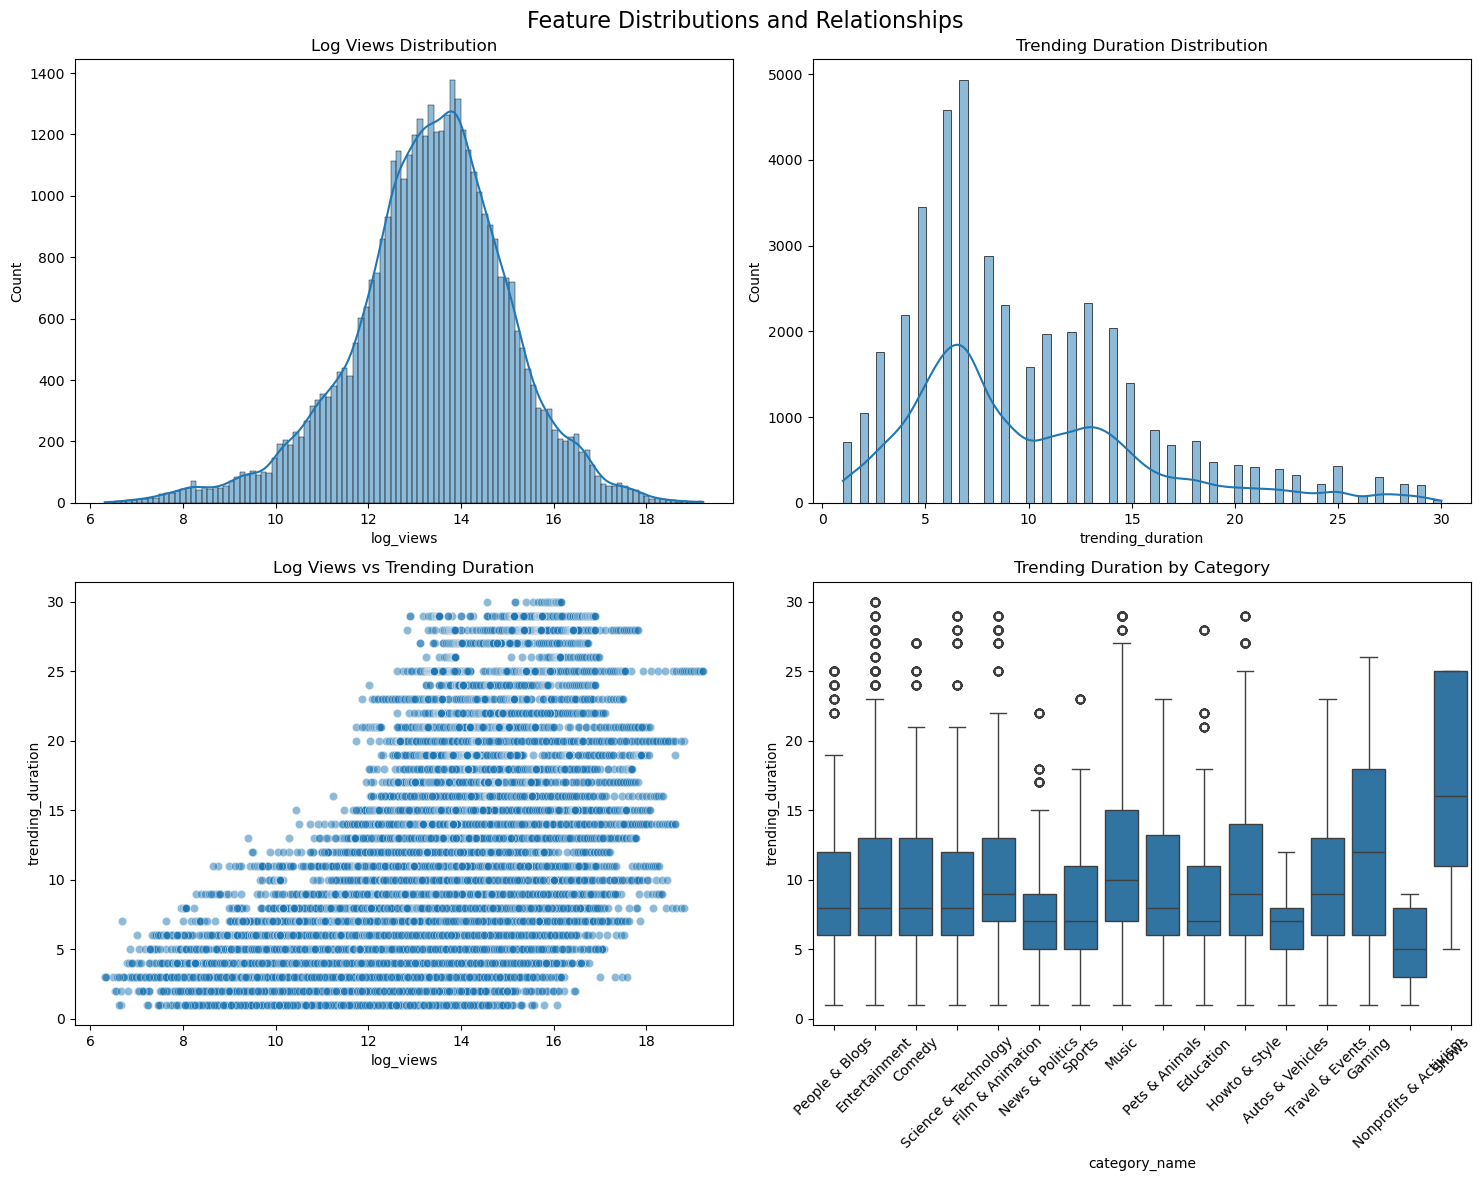

In [48]:
# Analyze feature distributions
analyze_feature_distributions(df)

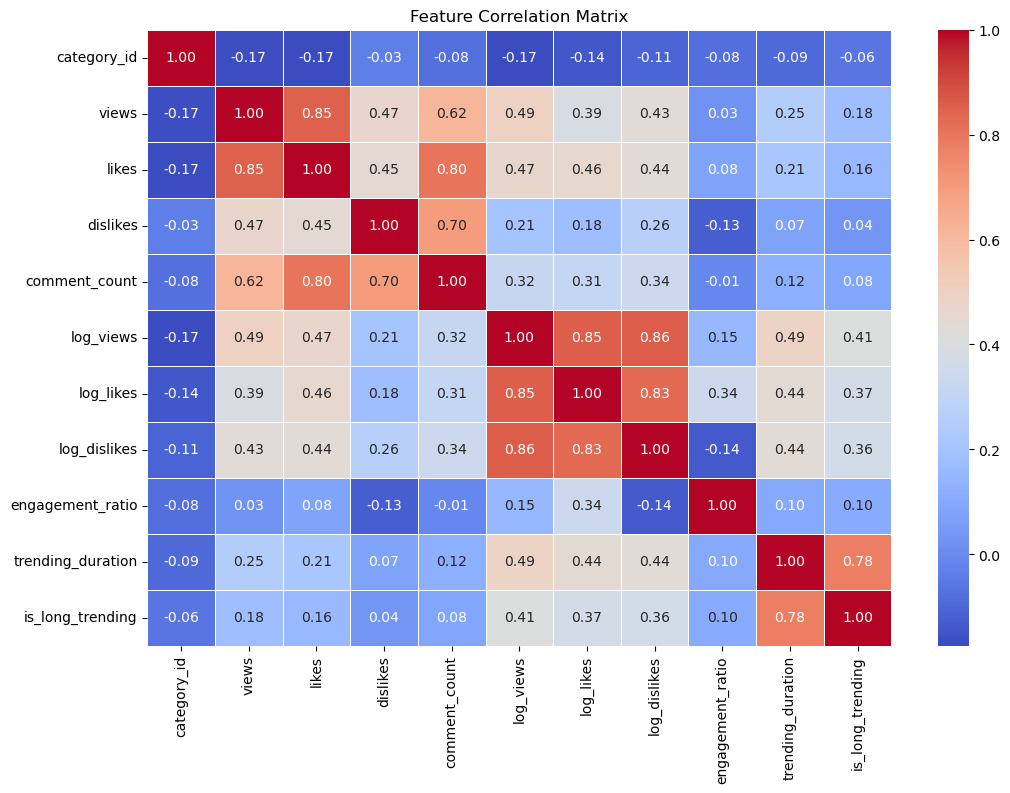

In [49]:
# Calculate the correlation matrix for numerical features only
def plot_correlation_matrix(df):
  numerical_features = df.select_dtypes(include=[np.number])
  corr_matrix = numerical_features.corr()

  plt.figure(figsize=(12, 8))
  sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
  plt.title('Feature Correlation Matrix')
  plt.show()

# Call the function
plot_correlation_matrix(df)

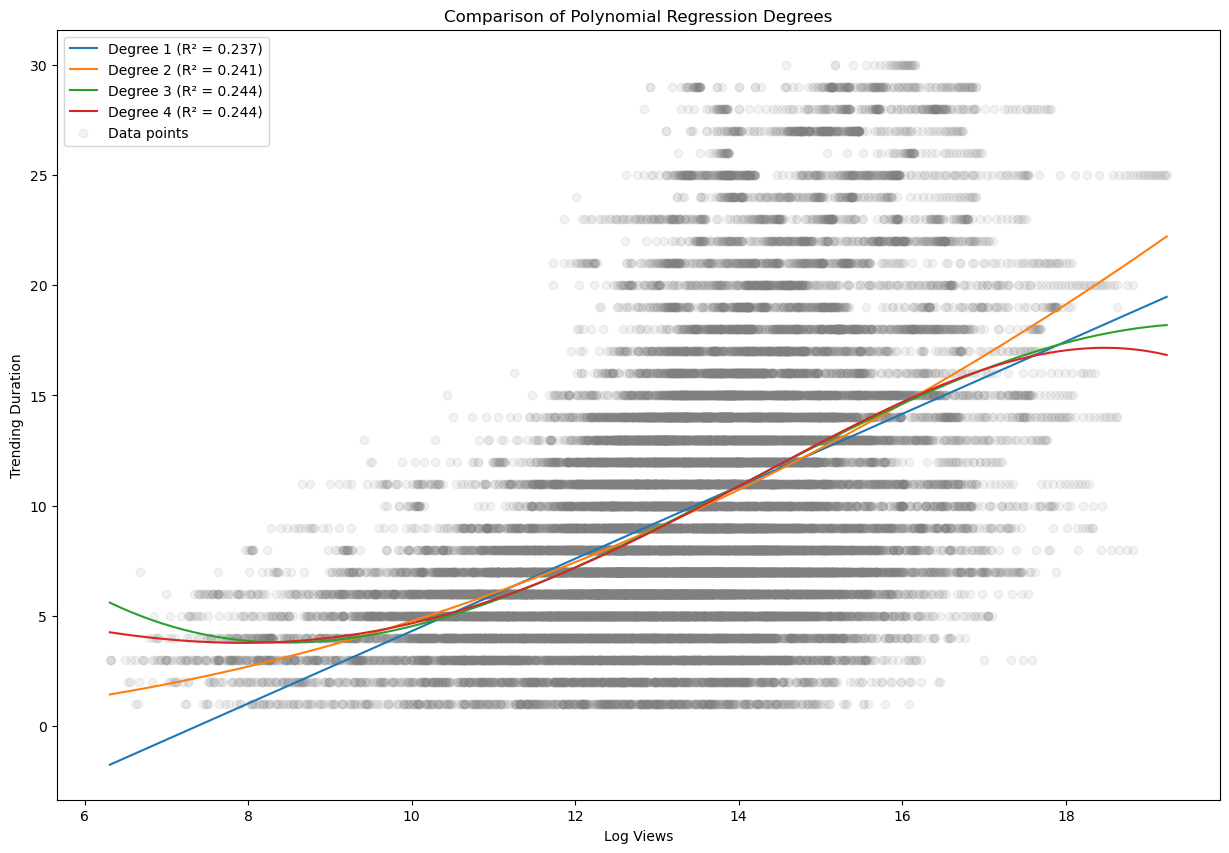

In [50]:
# Analyze polynomial degrees
analyze_polynomial_degrees(df)


Linear Regression Results:
--------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:      trending_duration   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     2611.
Date:                Fri, 29 Nov 2024   Prob (F-statistic):               0.00
Time:                        03:57:48   Log-Likelihood:                -99409.
No. Observations:               32759   AIC:                         1.988e+05
Df Residuals:                   32754   BIC:                         1.989e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

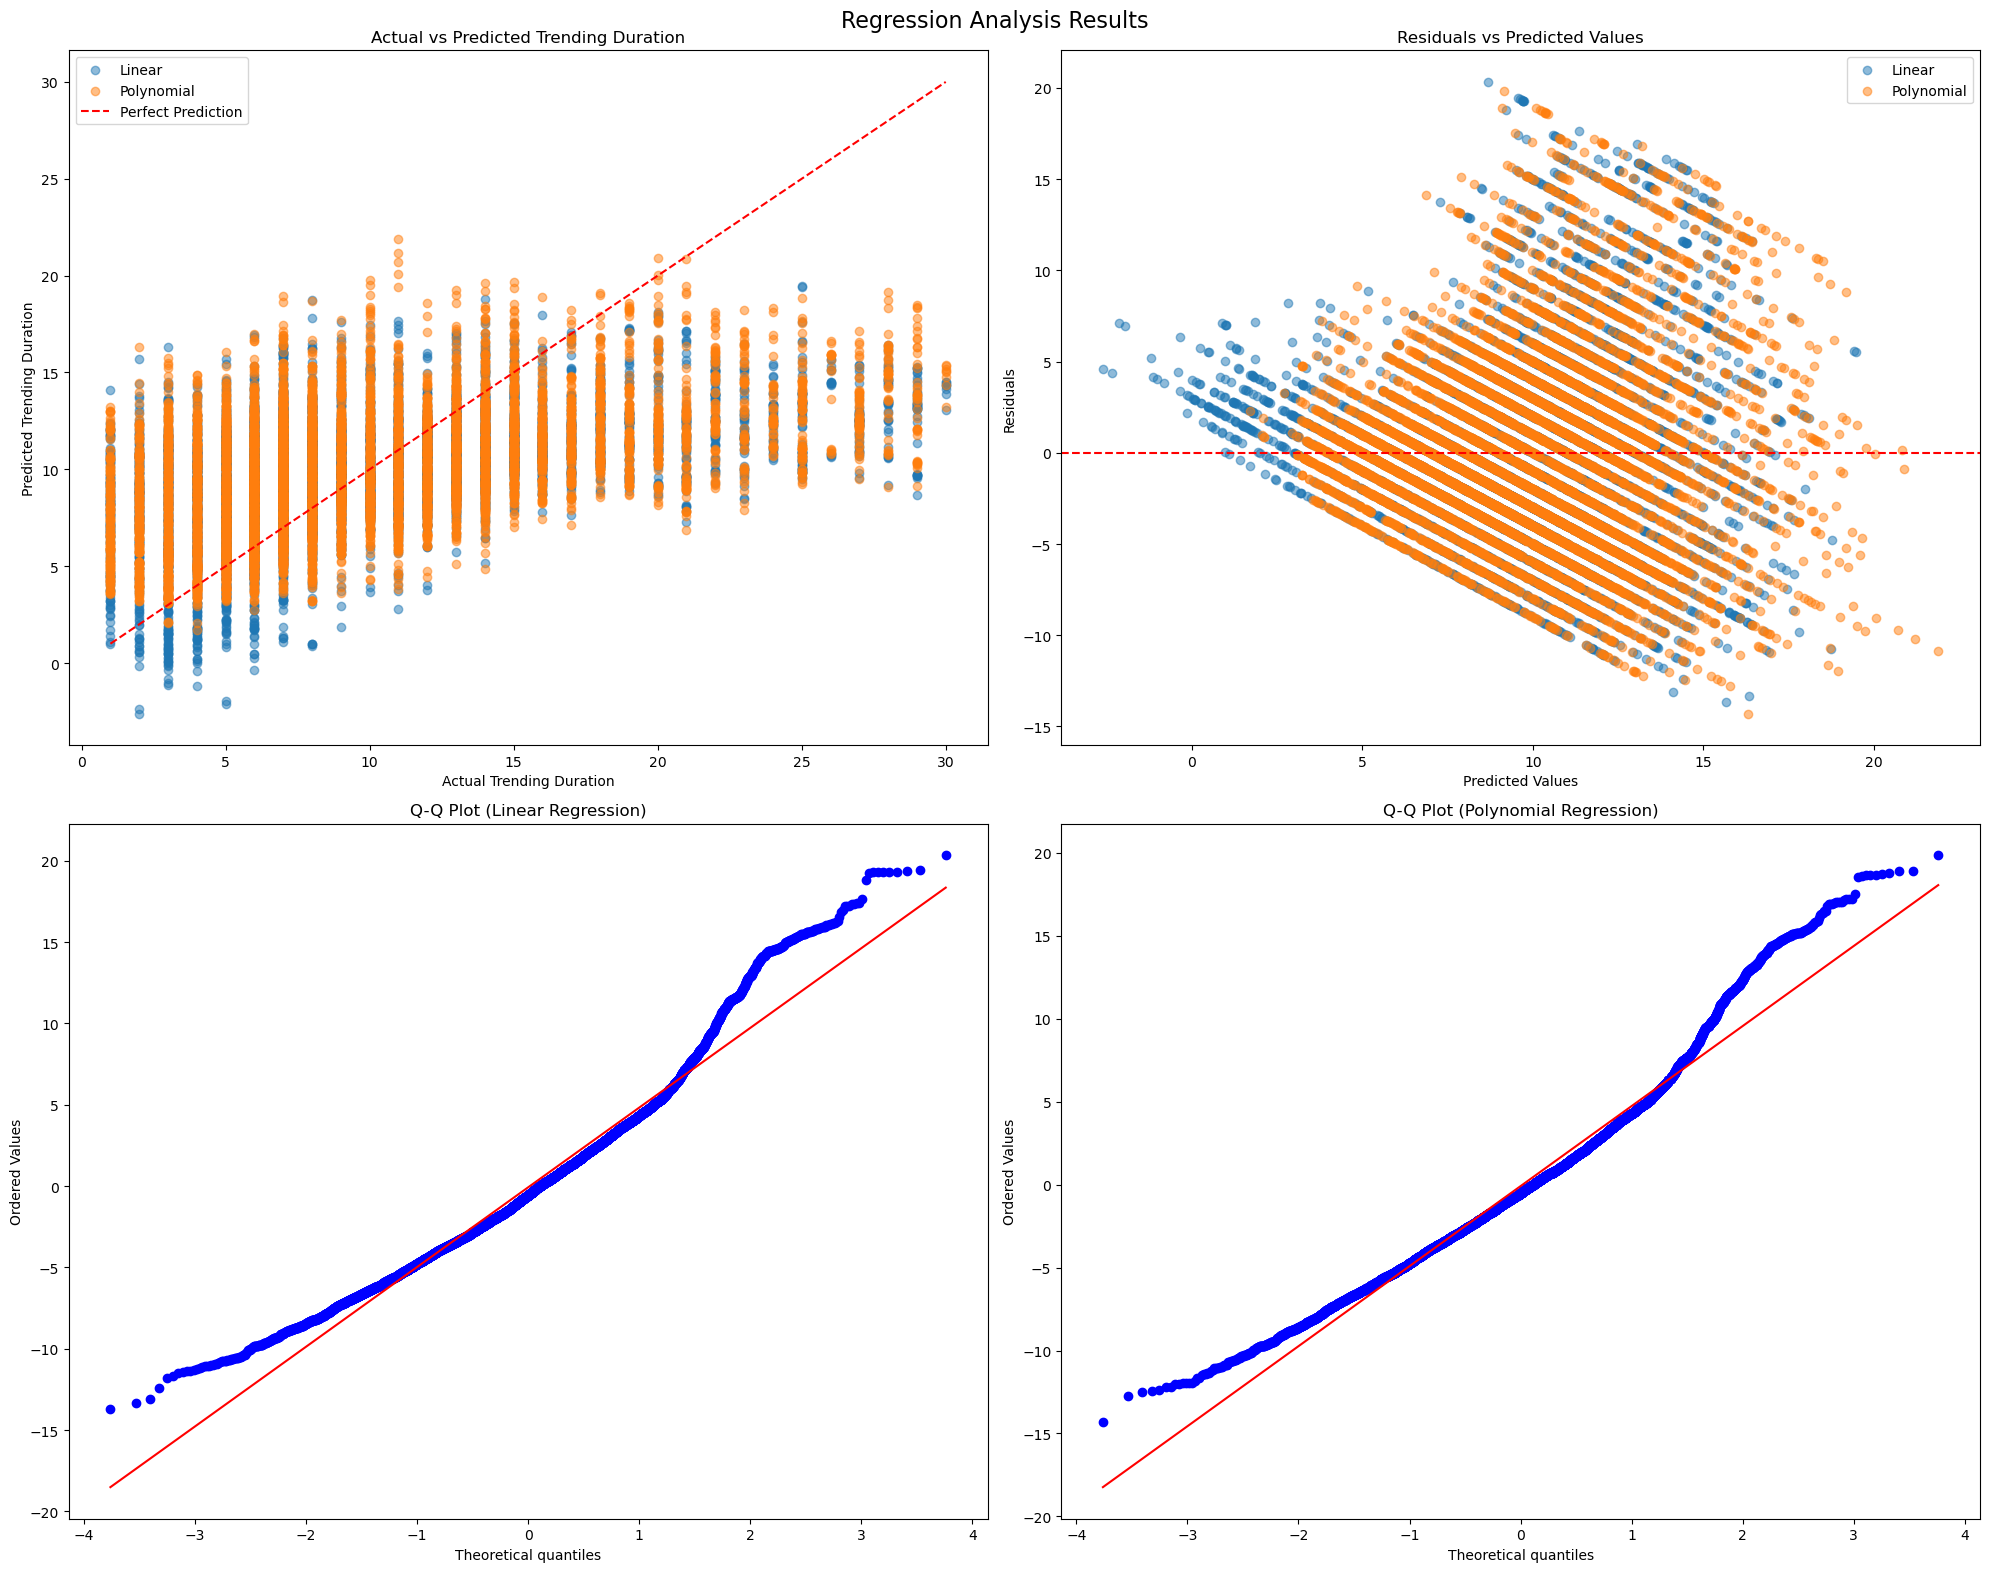

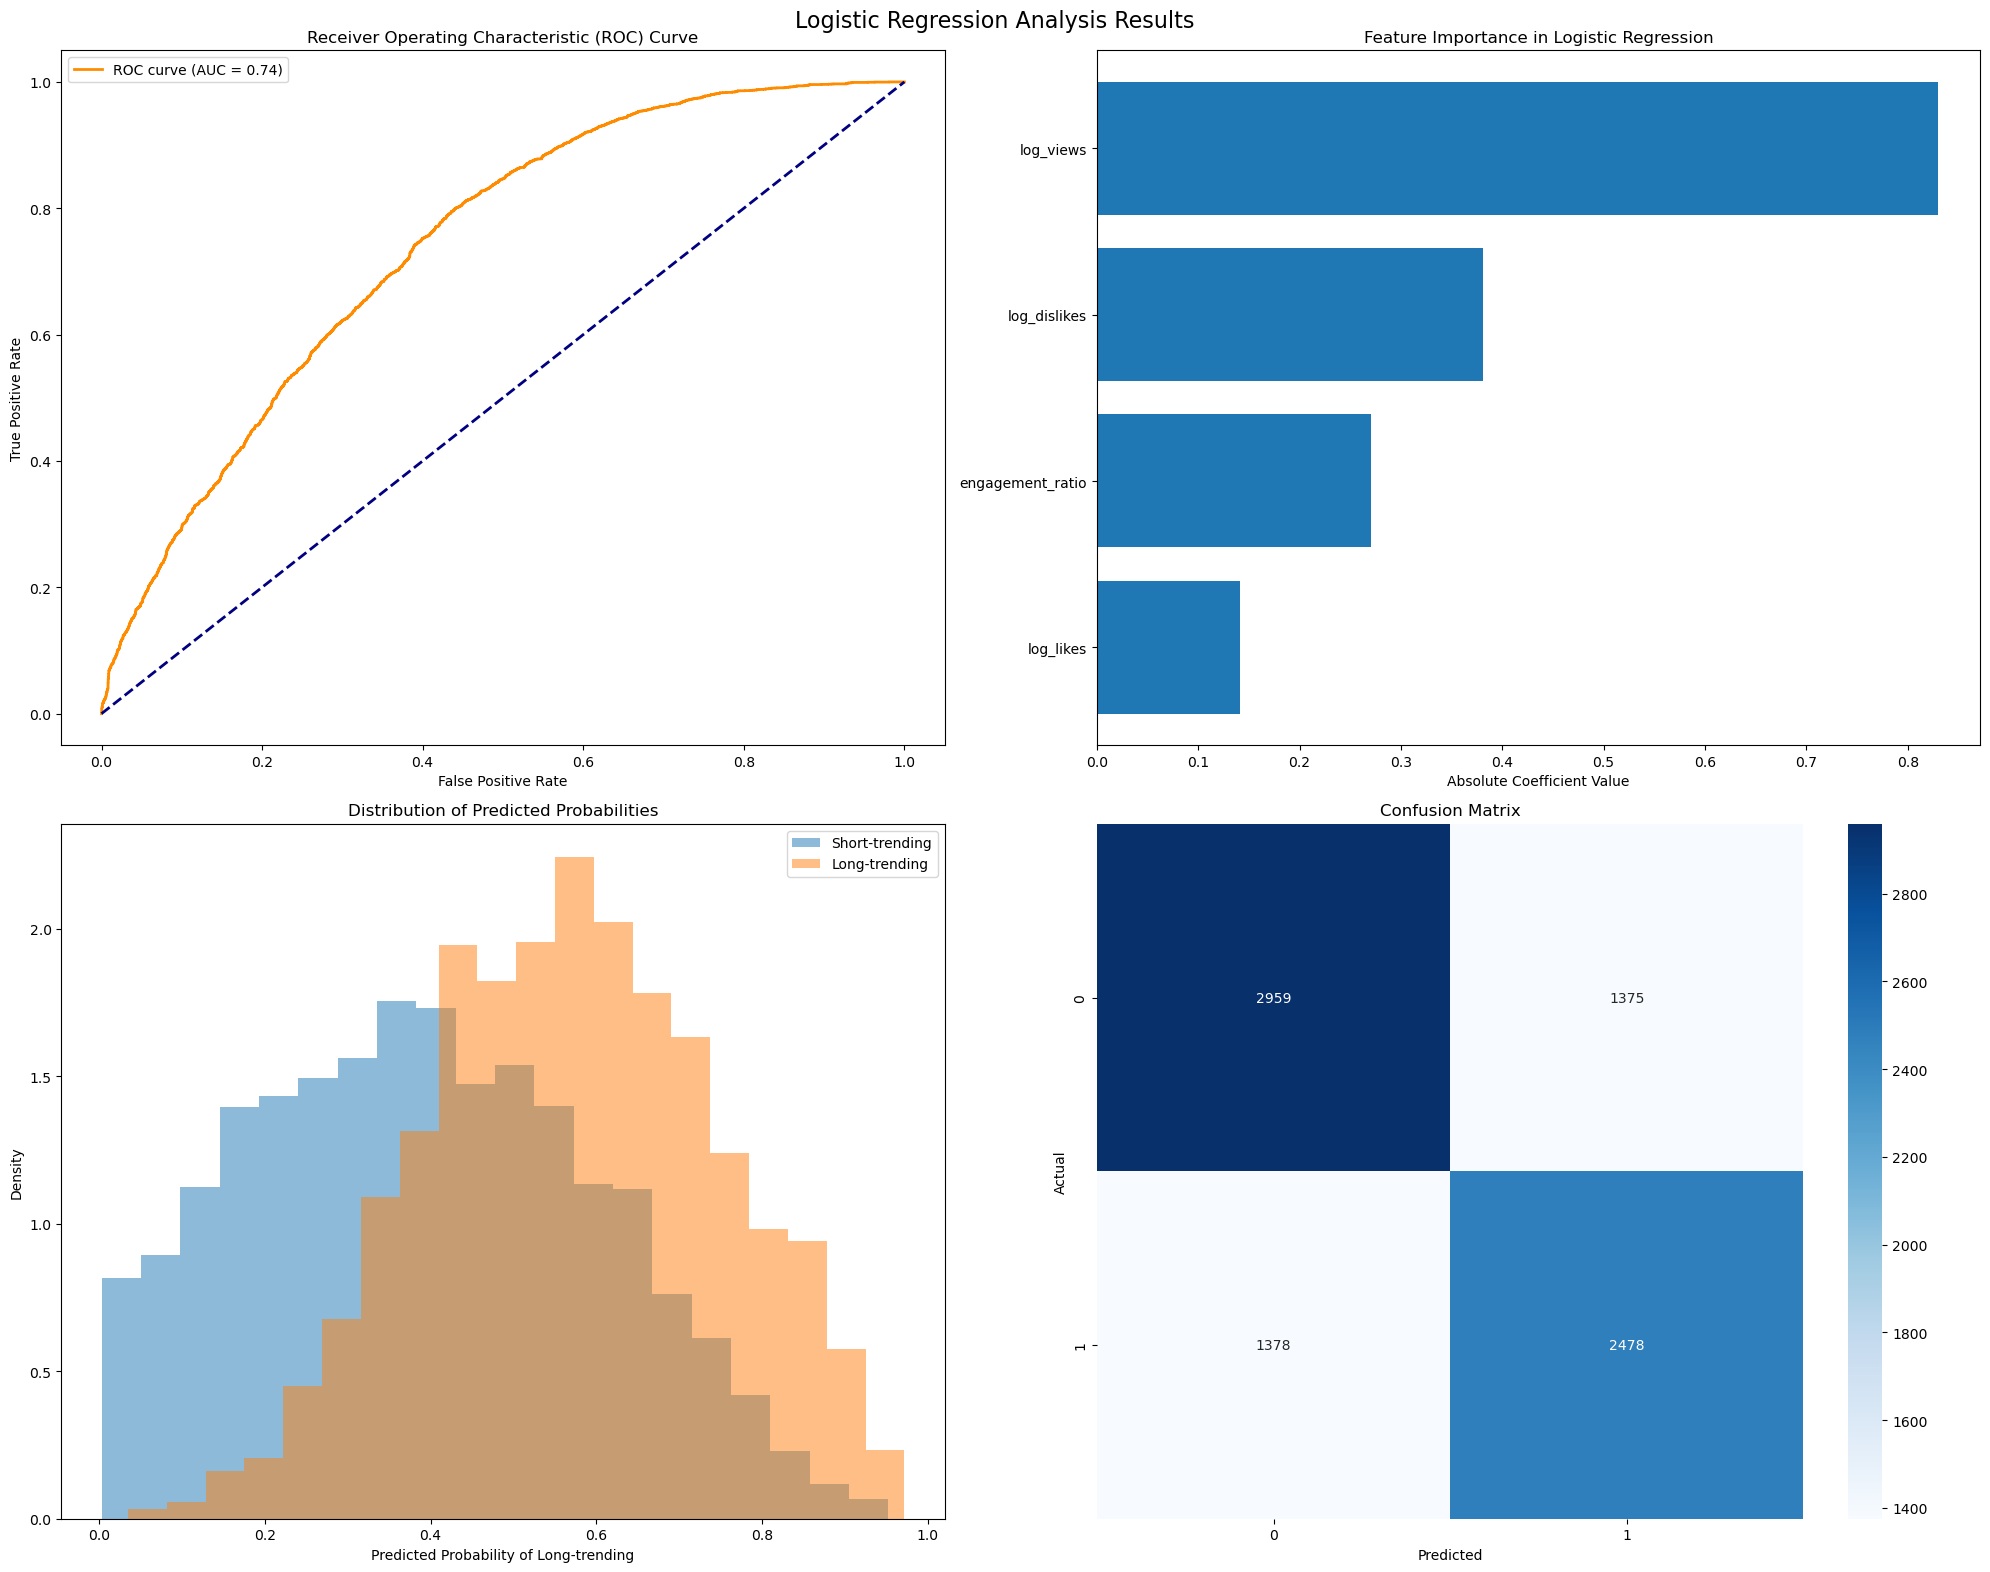

In [51]:
# Run models
perform_comprehensive_analysis(df)